**RNN과 CNN을 사용해 시퀀스 처리하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# 코랩에서 실행되는 노트북인가?
IS_COLAB = 'google.colab' in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')

# 깔끔한 그래프 출력을 위해
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, f'{fig_id}.{fig_extension}')
    print(f'그림 저장 {fig_id}')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

# 기본적인 RNN

## 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, n_steps]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps]
X_test, y_test = series[9000:, :n_steps], series[9000:, n_steps]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


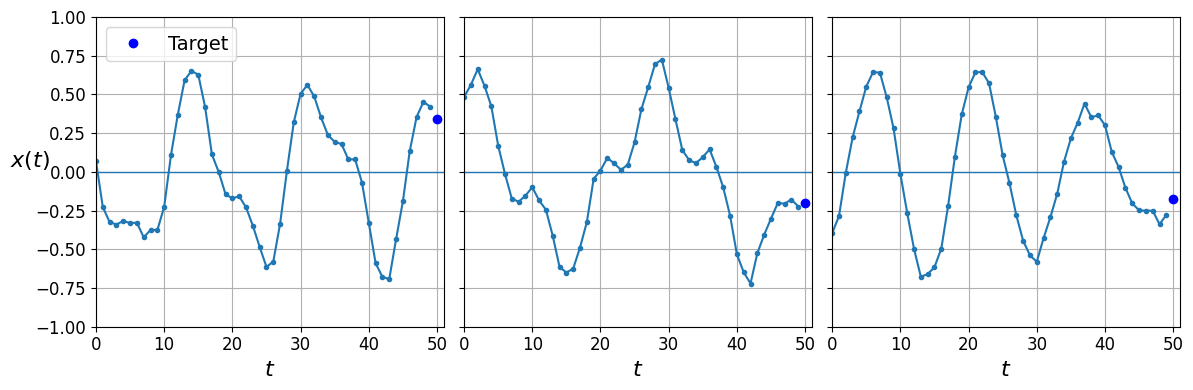

In [5]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'rx', markersize=10, label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc='upper left')


fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col == 0 else None), legend=(col == 0))
save_fig('time_series_plot')
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타낸다.

## 기준 성능 계산하기

단순한 예측 (마지막 관측값을 사용해 예측한다):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020495532

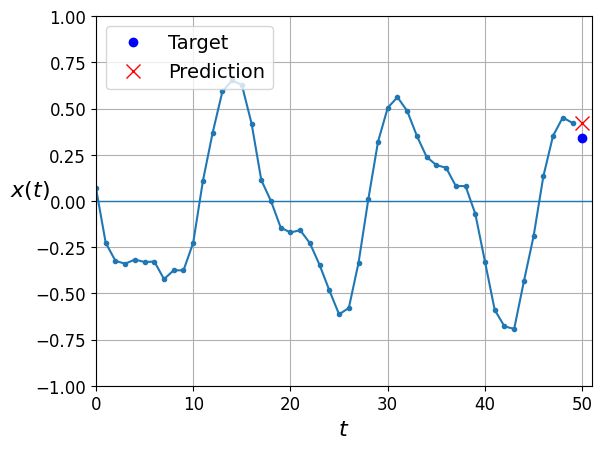

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

선형 예측:

In [8]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(1)])
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0498 - val_loss: 0.0213
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0155 - val_loss: 0.0113
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0100 - val_loss: 0.0090
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0048

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0037


0.0037436282727867365

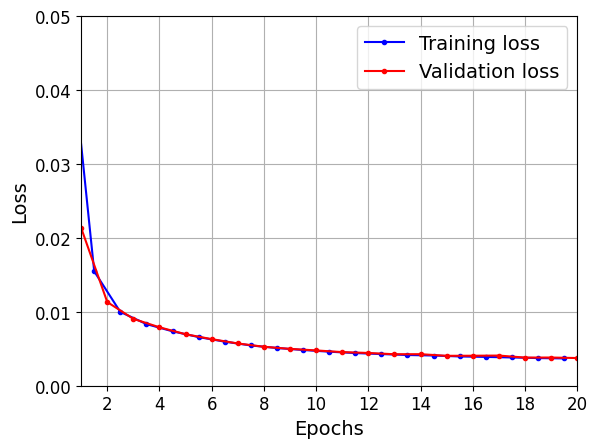

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)


plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 0s 977us/step


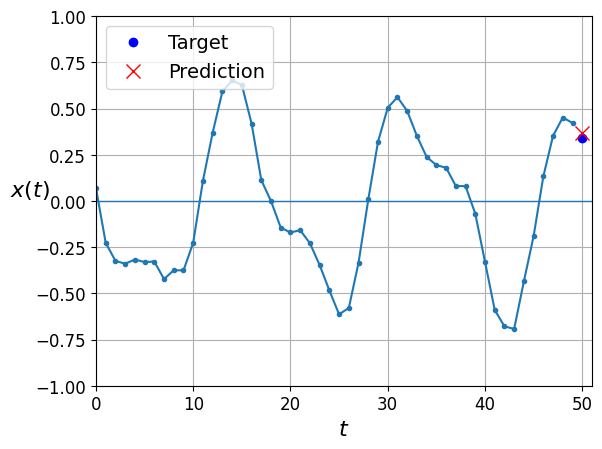

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 간단한 RNN 사용하기

In [12]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])
optimizer = keras.optimizers.Adam(0.005)
model.compile(optimizer, 'mse')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 14s 62ms/step - loss: 0.3242 - val_loss: 0.2230
Epoch 2/20
219/219 [==============================] - 14s 62ms/step - loss: 0.1568 - val_loss: 0.1109
Epoch 3/20
219/219 [==============================] - 12s 57ms/step - loss: 0.0714 - val_loss: 0.0423
Epoch 4/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0273 - val_loss: 0.0172
Epoch 5/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0137 - val_loss: 0.0116
Epoch 6/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 7/20
219/219 [==============================] - 11s 53ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 12s 56ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 10/20
219/219 [==============================] - 11s 52ms/step - loss: 0.011

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.0108


0.010800986550748348

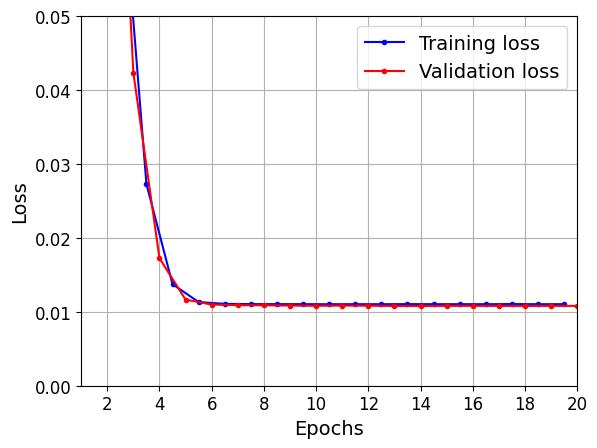

In [14]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 11ms/step


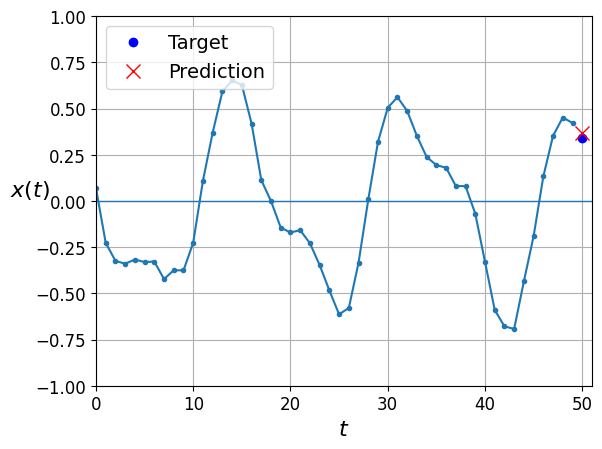

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 심층 RNN

In [16]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.SimpleRNN(1)
    ]
)
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 42s 187ms/step - loss: 0.0580 - val_loss: 0.0066
Epoch 2/20
219/219 [==============================] - 45s 208ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 3/20
219/219 [==============================] - 43s 196ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 4/20
219/219 [==============================] - 39s 178ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 5/20
219/219 [==============================] - 40s 181ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 6/20
219/219 [==============================] - 40s 182ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 7/20
219/219 [==============================] - 39s 180ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/20
219/219 [==============================] - 40s 181ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/20
219/219 [==============================] - 39s 179ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 40s 182ms/step - l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 2s 33ms/step - loss: 0.0031


0.00306755886413157

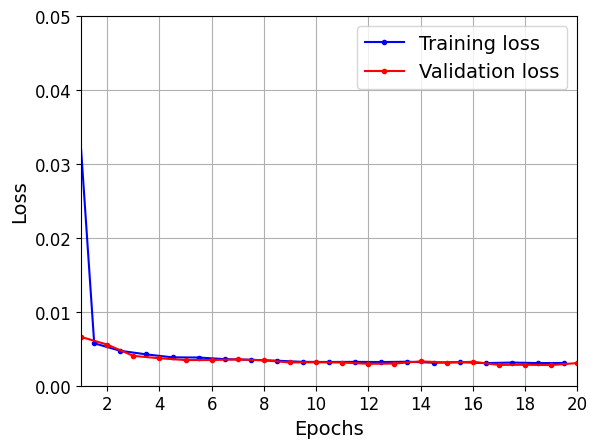

In [18]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 2s 30ms/step


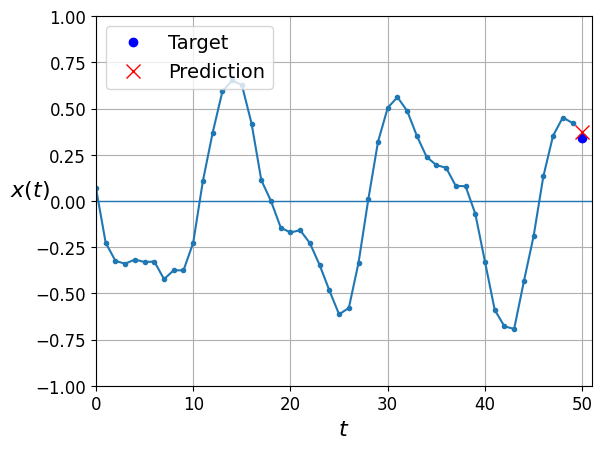

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

두 번째 `SimpleRNN` 층은 마지막 출력만 반환한다:

In [20]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(1)
    ]
)
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 26s 115ms/step - loss: 0.0214 - val_loss: 0.0053
Epoch 2/20
219/219 [==============================] - 25s 113ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 4/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 7/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 25s 115ms/step - l

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 20ms/step - loss: 0.0027


0.0027012862265110016

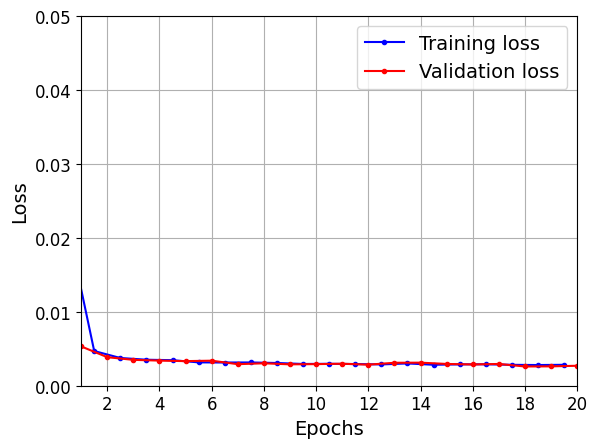

In [22]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 19ms/step


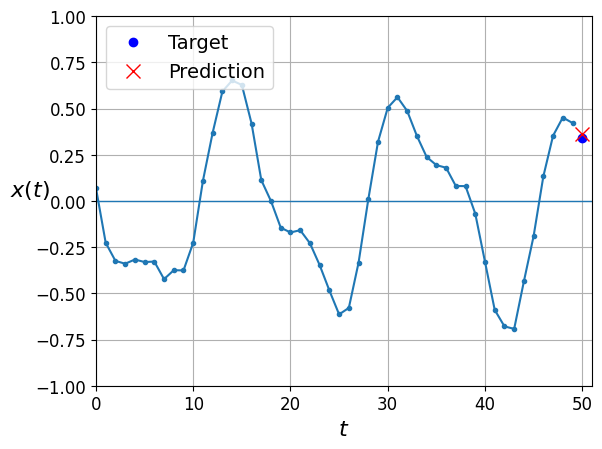

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 여러 타임 스텝 앞을 예측하기

In [24]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[np.newaxis]
    X = np.concatenate([X, y_pred_one], 1)
Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 36ms/step


In [25]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


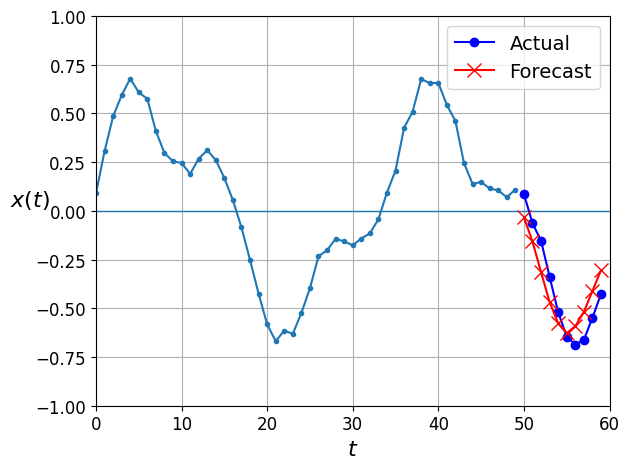

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'bo-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'rx-', label='Forecast', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig('forecast_ahead_plot')
plt.show()

이 모델을 사용해 다음 10개의 값을 예측해 본다. 먼저 아홉 개의 타임 스텝을 더 가진 시퀀스를 다시 생성해야 한다.

In [27]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, n_steps:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, n_steps:, 0]

이제 하나씩 다음 10개의 값을 예측한다:

In [28]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis]
    X = np.concatenate([X, y_pred_one], 1)
Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 2s 24ms/step


In [29]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.0307729

이 성능을 단순한 예측이나 간단한 선형 모델과 비교해 본다:

In [30]:
Y_naive_pred = np.tile(X_valid[:, -1], 10)  # 마지막 타임 스텝 값을 선택해 10번 반복한다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25957868

In [31]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(10)])
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1835 - val_loss: 0.0808
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0634 - val_loss: 0.0525
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0467 - val_loss: 0.0423
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0391 - val_loss: 0.0368
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0346 - val_loss: 0.0331
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0316 - val_loss: 0.0305
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0293 - val_loss: 0.0286
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0276 - val_loss: 0.0269
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0262 - val_loss: 0.0258
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0251 - val_loss: 0.0247

이제 동시에 다음 10개의 값을 모두 예측하는 RNN을 만들어 본다:

In [32]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(10)
    ]
)
model.compile('adam', 'mse')
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 27s 116ms/step - loss: 0.0681 - val_loss: 0.0344
Epoch 2/20
219/219 [==============================] - 26s 120ms/step - loss: 0.0279 - val_loss: 0.0224
Epoch 3/20
219/219 [==============================] - 29s 134ms/step - loss: 0.0192 - val_loss: 0.0168
Epoch 4/20
219/219 [==============================] - 29s 135ms/step - loss: 0.0155 - val_loss: 0.0136
Epoch 5/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0135 - val_loss: 0.0139
Epoch 6/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0125 - val_loss: 0.0157
Epoch 7/20
219/219 [==============================] - 29s 134ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 8/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 28s 130ms/step - loss: 0.0112 - val_loss: 0.0138
Epoch 10/20
219/219 [==============================] - 27s 125ms/step - l

In [33]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 234ms/step


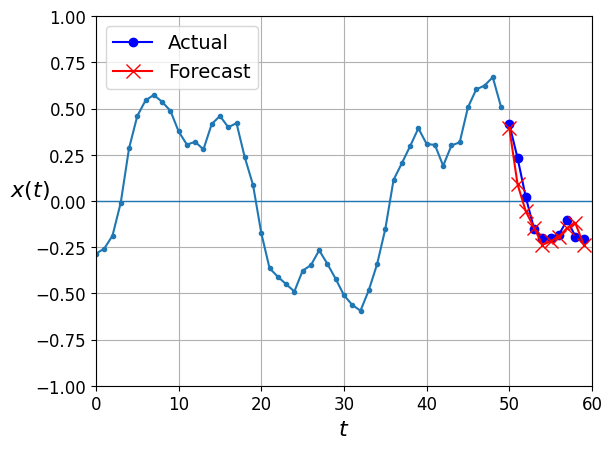

In [34]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

이제 타임 스텝마다 다음 10 스텝을 예측하는 RNN을 만들어 본다. 즉 타임 스텝 0에서 49까지를 기반으로 타임 스텝 50에서 59를 예측하는 것이 아니라, 타임 스텝 0에서 타임 스텝 1에서 10까지 예측하고 그다음 타임 스텝 1에서 타임 스텝 2에서 11까지 예측한다. 마지막 타임 스텝에서는 타임 스텝 50에서 59까지 예측한다. 이 모델은 인과 모델이다. 어떤 타임 스텝에서 예측을 만들 때 과거 타임 스텝만 볼 수 있다.

In [35]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [36]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [37]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(keras.optimizers.Adam(0.01), 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 28s 123ms/step - loss: 0.0490 - last_time_step_mse: 0.0382 - val_loss: 0.0380 - val_last_time_step_mse: 0.0252
Epoch 2/20
219/219 [==============================] - 28s 130ms/step - loss: 0.0356 - last_time_step_mse: 0.0238 - val_loss: 0.0324 - val_last_time_step_mse: 0.0211
Epoch 3/20
219/219 [==============================] - 28s 127ms/step - loss: 0.0306 - last_time_step_mse: 0.0184 - val_loss: 0.0285 - val_last_time_step_mse: 0.0191
Epoch 4/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0274 - last_time_step_mse: 0.0151 - val_loss: 0.0255 - val_last_time_step_mse: 0.0133
Epoch 5/20
219/219 [==============================] - 27s 125ms/step - loss: 0.0265 - last_time_step_mse: 0.0146 - val_loss: 0.0244 - val_last_time_step_mse: 0.0138
Epoch 6/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0241 - last_time_step_mse: 0.0123 - val_loss: 0.0229 - val_last_time_step_mse: 0.0120
Epoch 7/20

In [38]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 243ms/step


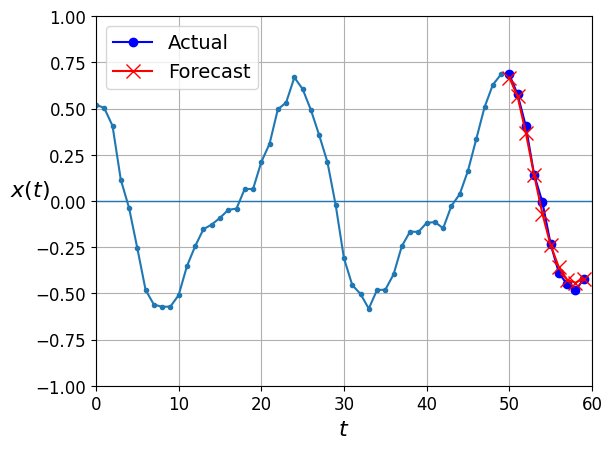

In [39]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 배치 정규화를 사용한 심층 RNN

In [40]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.BatchNormalization(),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 27s 118ms/step - loss: 0.1967 - last_time_step_mse: 0.1843 - val_loss: 0.0754 - val_last_time_step_mse: 0.0642
Epoch 2/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0556 - last_time_step_mse: 0.0452 - val_loss: 0.0508 - val_last_time_step_mse: 0.0415
Epoch 3/20
219/219 [==============================] - 27s 125ms/step - loss: 0.0476 - last_time_step_mse: 0.0376 - val_loss: 0.0457 - val_last_time_step_mse: 0.0359
Epoch 4/20
219/219 [==============================] - 28s 128ms/step - loss: 0.0429 - last_time_step_mse: 0.0324 - val_loss: 0.0412 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 27s 122ms/step - loss: 0.0392 - last_time_step_mse: 0.0272 - val_loss: 0.0378 - val_last_time_step_mse: 0.0256
Epoch 6/20
219/219 [==============================] - 28s 126ms/step - loss: 0.0362 - last_time_step_mse: 0.0230 - val_loss: 0.0366 - val_last_time_step_mse: 0.0230
Epoch 7/20

# 층 정규화를 사용한 심층 RNN

In [41]:
from tensorflow.keras.layers import LayerNormalization

In [42]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [43]:
model = keras.models.Sequential(
    [
        keras.layers.RNN(LNSimpleRNNCell(20), True, input_shape=[None, 1]),
        keras.layers.RNN(LNSimpleRNNCell(20), True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 59s 259ms/step - loss: 0.1179 - last_time_step_mse: 0.1035 - val_loss: 0.0608 - val_last_time_step_mse: 0.0499
Epoch 2/20
219/219 [==============================] - 56s 257ms/step - loss: 0.0569 - last_time_step_mse: 0.0466 - val_loss: 0.0532 - val_last_time_step_mse: 0.0440
Epoch 3/20
219/219 [==============================] - 56s 254ms/step - loss: 0.0501 - last_time_step_mse: 0.0389 - val_loss: 0.0447 - val_last_time_step_mse: 0.0320
Epoch 4/20
219/219 [==============================] - 55s 249ms/step - loss: 0.0422 - last_time_step_mse: 0.0282 - val_loss: 0.0370 - val_last_time_step_mse: 0.0214
Epoch 5/20
219/219 [==============================] - 57s 261ms/step - loss: 0.0354 - last_time_step_mse: 0.0200 - val_loss: 0.0333 - val_last_time_step_mse: 0.0177
Epoch 6/20
219/219 [==============================] - 57s 259ms/step - loss: 0.0328 - last_time_step_mse: 0.0179 - val_loss: 0.0313 - val_last_time_step_mse: 0.0158
Epoch 7/20

# 사용자 정의 RNN 클래스 만들기

In [44]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(self.cell, 'get_initial_state', self.fallback_initial_state)

    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(inputs.dtype, (n_steps if self.return_sequences else 0))
        outputs = tf.zeros([batch_size, self.cell.output_size], inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [45]:
model = keras.models.Sequential(
    [
        MyRNN(LNSimpleRNNCell(20), True, input_shape=[None, 1]),
        MyRNN(LNSimpleRNNCell(20), True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 61s 271ms/step - loss: 0.1412 - last_time_step_mse: 0.1312 - val_loss: 0.0604 - val_last_time_step_mse: 0.0472
Epoch 2/20
219/219 [==============================] - 61s 277ms/step - loss: 0.0554 - last_time_step_mse: 0.0421 - val_loss: 0.0511 - val_last_time_step_mse: 0.0379
Epoch 3/20
219/219 [==============================] - 61s 278ms/step - loss: 0.0481 - last_time_step_mse: 0.0340 - val_loss: 0.0450 - val_last_time_step_mse: 0.0300
Epoch 4/20
219/219 [==============================] - 61s 277ms/step - loss: 0.0423 - last_time_step_mse: 0.0275 - val_loss: 0.0395 - val_last_time_step_mse: 0.0244
Epoch 5/20
219/219 [==============================] - 62s 283ms/step - loss: 0.0383 - last_time_step_mse: 0.0237 - val_loss: 0.0362 - val_last_time_step_mse: 0.0222
Epoch 6/20
219/219 [==============================] - 61s 280ms/step - loss: 0.0361 - last_time_step_mse: 0.0219 - val_loss: 0.0346 - val_last_time_step_mse: 0.0208
Epoch 7/20

In [46]:
model = keras.models.Sequential(
    [
        keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 20ms/step - loss: 0.0763 - last_time_step_mse: 0.0621 - val_loss: 0.0531 - val_last_time_step_mse: 0.0387
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0465 - last_time_step_mse: 0.0279 - val_loss: 0.0399 - val_last_time_step_mse: 0.0207
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0375 - last_time_step_mse: 0.0181 - val_loss: 0.0341 - val_last_time_step_mse: 0.0153
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0337 - last_time_step_mse: 0.0146 - val_loss: 0.0315 - val_last_time_step_mse: 0.0134
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0314 - last_time_step_mse: 0.0130 - val_loss: 0.0300 - val_last_time_step_mse: 0.0132
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0296 - last_time_step_mse: 0.0116 - val_loss: 0.0284 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [==

In [47]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0239 - last_time_step_mse: 0.0091


[0.02386750653386116, 0.009052029810845852]

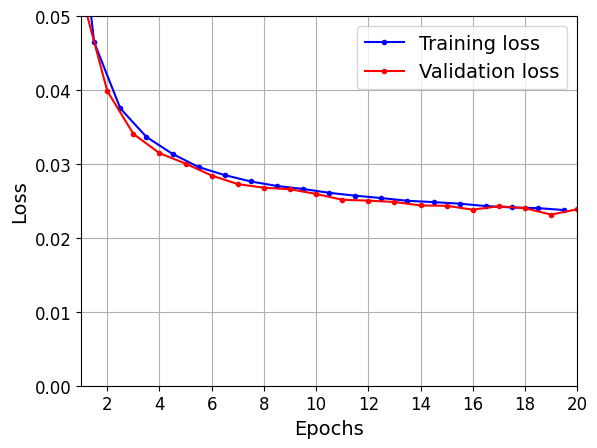

In [48]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [49]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 603ms/step


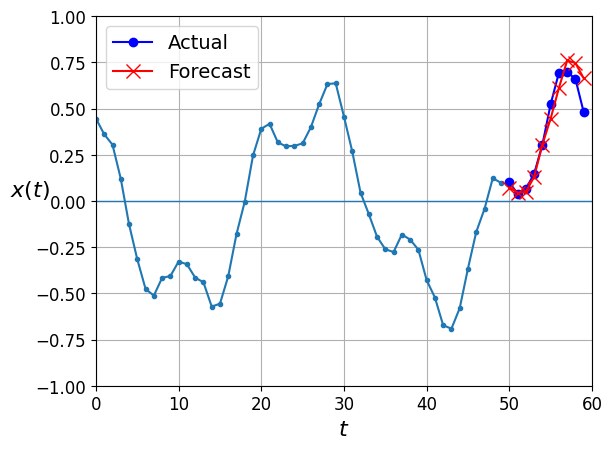

In [50]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRU

In [51]:
model = keras.models.Sequential(
    [
        keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 19ms/step - loss: 0.0797 - last_time_step_mse: 0.0712 - val_loss: 0.0540 - val_last_time_step_mse: 0.0439
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0498 - last_time_step_mse: 0.0395 - val_loss: 0.0449 - val_last_time_step_mse: 0.0353
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0442 - last_time_step_mse: 0.0335 - val_loss: 0.0407 - val_last_time_step_mse: 0.0308
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0396 - last_time_step_mse: 0.0284 - val_loss: 0.0364 - val_last_time_step_mse: 0.0252
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0357 - last_time_step_mse: 0.0239 - val_loss: 0.0331 - val_last_time_step_mse: 0.0227
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0320 - last_time_step_mse: 0.0176 - val_loss: 0.0297 - val_last_time_step_mse: 0.0153
Epoch 7/20
219/219 [==

In [52]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0239 - last_time_step_mse: 0.0103


[0.023911723867058754, 0.010311317630112171]

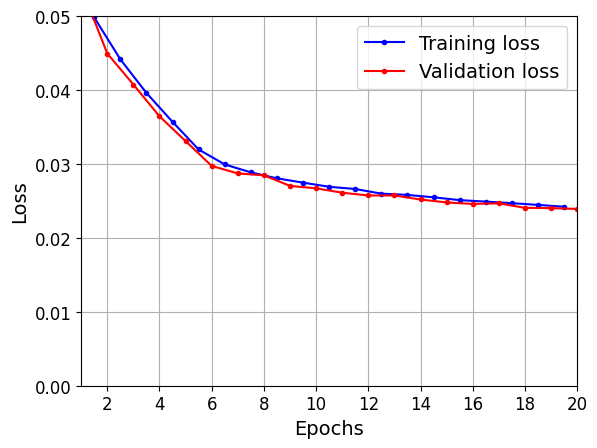

In [53]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [54]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 546ms/step


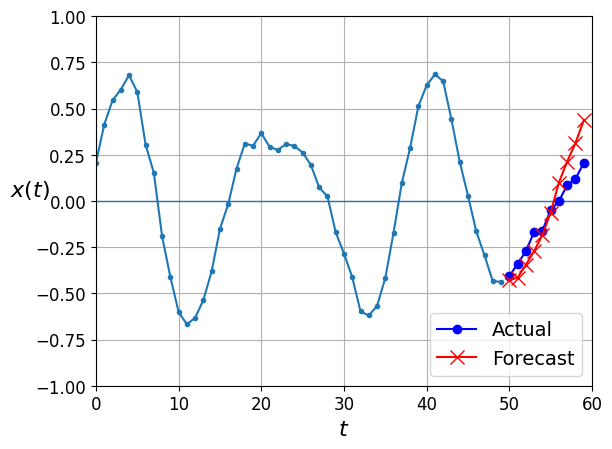

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [56]:
model = keras.models.Sequential(
    [
        keras.layers.Conv1D(20, 4, 2, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 6s 16ms/step - loss: 0.0677 - last_time_step_mse: 0.0592 - val_loss: 0.0438 - val_last_time_step_mse: 0.0365
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0379 - last_time_step_mse: 0.0307 - val_loss: 0.0343 - val_last_time_step_mse: 0.0282
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0309 - last_time_step_mse: 0.0222 - val_loss: 0.0292 - val_last_time_step_mse: 0.0204
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0272 - last_time_step_mse: 0.0171 - val_loss: 0.0252 - val_last_time_step_mse: 0.0145
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0247 - last_time_step_mse: 0.0138 - val_loss: 0.0237 - val_last_time_step_mse: 0.0128
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0232 - last_time_step_mse: 0.0122 - val_loss: 0.0223 - val_last_time_step_mse: 0.0111
Epoch 7/20
219/219 [==

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [57]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer([None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(20, 2, padding='causal', activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(10, 1))
model.compile('adam', 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 14ms/step - loss: 0.0666 - last_time_step_mse: 0.0530 - val_loss: 0.0367 - val_last_time_step_mse: 0.0217
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0336 - last_time_step_mse: 0.0188 - val_loss: 0.0299 - val_last_time_step_mse: 0.0164
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0289 - last_time_step_mse: 0.0154 - val_loss: 0.0270 - val_last_time_step_mse: 0.0146
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0266 - last_time_step_mse: 0.0137 - val_loss: 0.0250 - val_last_time_step_mse: 0.0127
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0253 - last_time_step_mse: 0.0126 - val_loss: 0.0240 - val_last_time_step_mse: 0.0118
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0243 - last_time_step_mse: 0.0119 - val_loss: 0.0232 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

다음은 논문에 정의된 원본 WaveNet이다. ReLU 대신에 GatedActivationUnit과 스킵 연결을 사용한다. 또한 점점 더 시퀀스가 짧아지는 것을 피하기 위해 왼쪽에 0으로 패딩한다:

In [58]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [59]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, 2, padding='causal', dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, 1)(z)
    return keras.layers.Add()([z, inputs]), z

In [60]:
n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 10  # 256 in the paper
inputs = keras.layers.Input([None, 1])
z = keras.layers.Conv1D(n_filters, 2, padding='causal')(inputs)
skip_to_last = []
for dilation_rate in [2 ** i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, 1, activation='relu')(z)
Y_proba = keras.layers.Conv1D(n_outputs, 1, activation='softmax')(z)
model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [61]:
model.compile('adam', 'mse', [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2, validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 4s 14ms/step - loss: 0.1300 - last_time_step_mse: 0.1244 - val_loss: 0.1221 - val_last_time_step_mse: 0.1182
Epoch 2/2
219/219 [==============================] - 3s 12ms/step - loss: 0.1219 - last_time_step_mse: 0.1161 - val_loss: 0.1212 - val_last_time_step_mse: 0.1174


이 장에서 RNN의 기초 사항을 살펴보았고 RNN을 사용해 시퀀스(소위 시계열)을 처리했다. CNN을 포함하여 시퀀스를 처리하는 다른 방법도 알아보았다. 다음에는 RNN을 자연어 처리에 적용해 보겠다. 그리고 RNN에 대해 더 자세히 배워 보겠다(양방향 RNN, 상태가 있는 RNN과 상태가 없는 RNN, 인코더-디코더, 어텐션을 사용한 인코더-디코더). 또한 어텐션만 사용하는 구조인 트랜스포머도 살펴보겠다.

# 연습

## 1. SketchRNN 데이터셋 다루기

_연습: 텐서플로 데이터셋에서 제공하는 SketchRNN 데이터셋으로 분류 모델을 훈련해 본다._

이 데이터셋은 아직 TFDS에서 제공하지 않는다. 아직 [풀 리퀘스트](https://github.com/tensorflow/datasets/pull/361)가 진행 중이다. 다행히 이 데이터는 TFRecord로 제공되므로 다운로드해 본다(3,450,000 훈련 스케치와 345,000 테스트 스케치가 포함된 이 데이터셋은 1GB 정도되기 때문에 다운로드 시간이 조금 걸린다):

In [62]:
DOWNLOAD_ROOT = 'http://download.tensorflow.org/data/'
FILENAME = 'quickdraw_tutorial_dataset_v1.tar.gz'
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, cache_subdir='datasets/quickdraw', extract=True)

In [63]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob('training.tfrecord-*')])
eval_files = sorted([str(path) for path in quickdraw_dir.glob('eval.tfrecord-*')])

In [64]:
train_files

['C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [65]:
eval_files

['C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [66]:
with open(quickdraw_dir / 'eval.tfrecord.classes') as test_classes_file:
    test_classes = test_classes_file.readlines()
with open(quickdraw_dir / 'training.tfrecord.classes') as train_classes_file:
    train_classes = train_classes_file.readlines()

In [67]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [68]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [69]:
def parse(data_batch):
    feature_descriptions = {
        'ink': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.FixedLenFeature([2], tf.int64),
        'class_index': tf.io.FixedLenFeature([1], tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples['ink'])
    sketches = tf.reshape(flat_sketches, [tf.size(data_batch), -1, 3])
    lengths = examples['shape'][:, 0]
    labels = examples['class_index'][:, 0]
    return sketches, lengths, labels

In [70]:
AUTOTUNE = tf.data.AUTOTUNE


def quickdraw_dataset(
        filepaths,
        batch_size=32,
        shuffle_buffer_size=None,
        n_parse_threads=AUTOTUNE,
        n_read_threads=AUTOTUNE,
        cache=False
):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, n_parse_threads)
    return dataset.prefetch(AUTOTUNE)

In [71]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [72]:
for sketches, lengths, labels in train_set.take(1):
    print(f'sketches = {sketches}')
    print(f'lengths = {lengths}')
    print(f'labels = {labels}')

sketches = [[[ 0.25490198 -0.13483143  0.        ]
  [ 0.10196078 -0.02247196  0.        ]
  [ 0.17254904  0.05617982  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.5647059   0.01801801  0.        ]
  [ 0.4352941  -0.04504504  1.        ]
  [-0.827451    0.15315315  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.05098039  0.          0.        ]
  [-0.0509804   0.04379562  0.        ]
  [-0.10980392  0.16058394  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.24200915  0.03921569  0.        ]
  [-0.06849315  0.02352941  0.        ]
  [-0.06392694  0.04705882  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.   

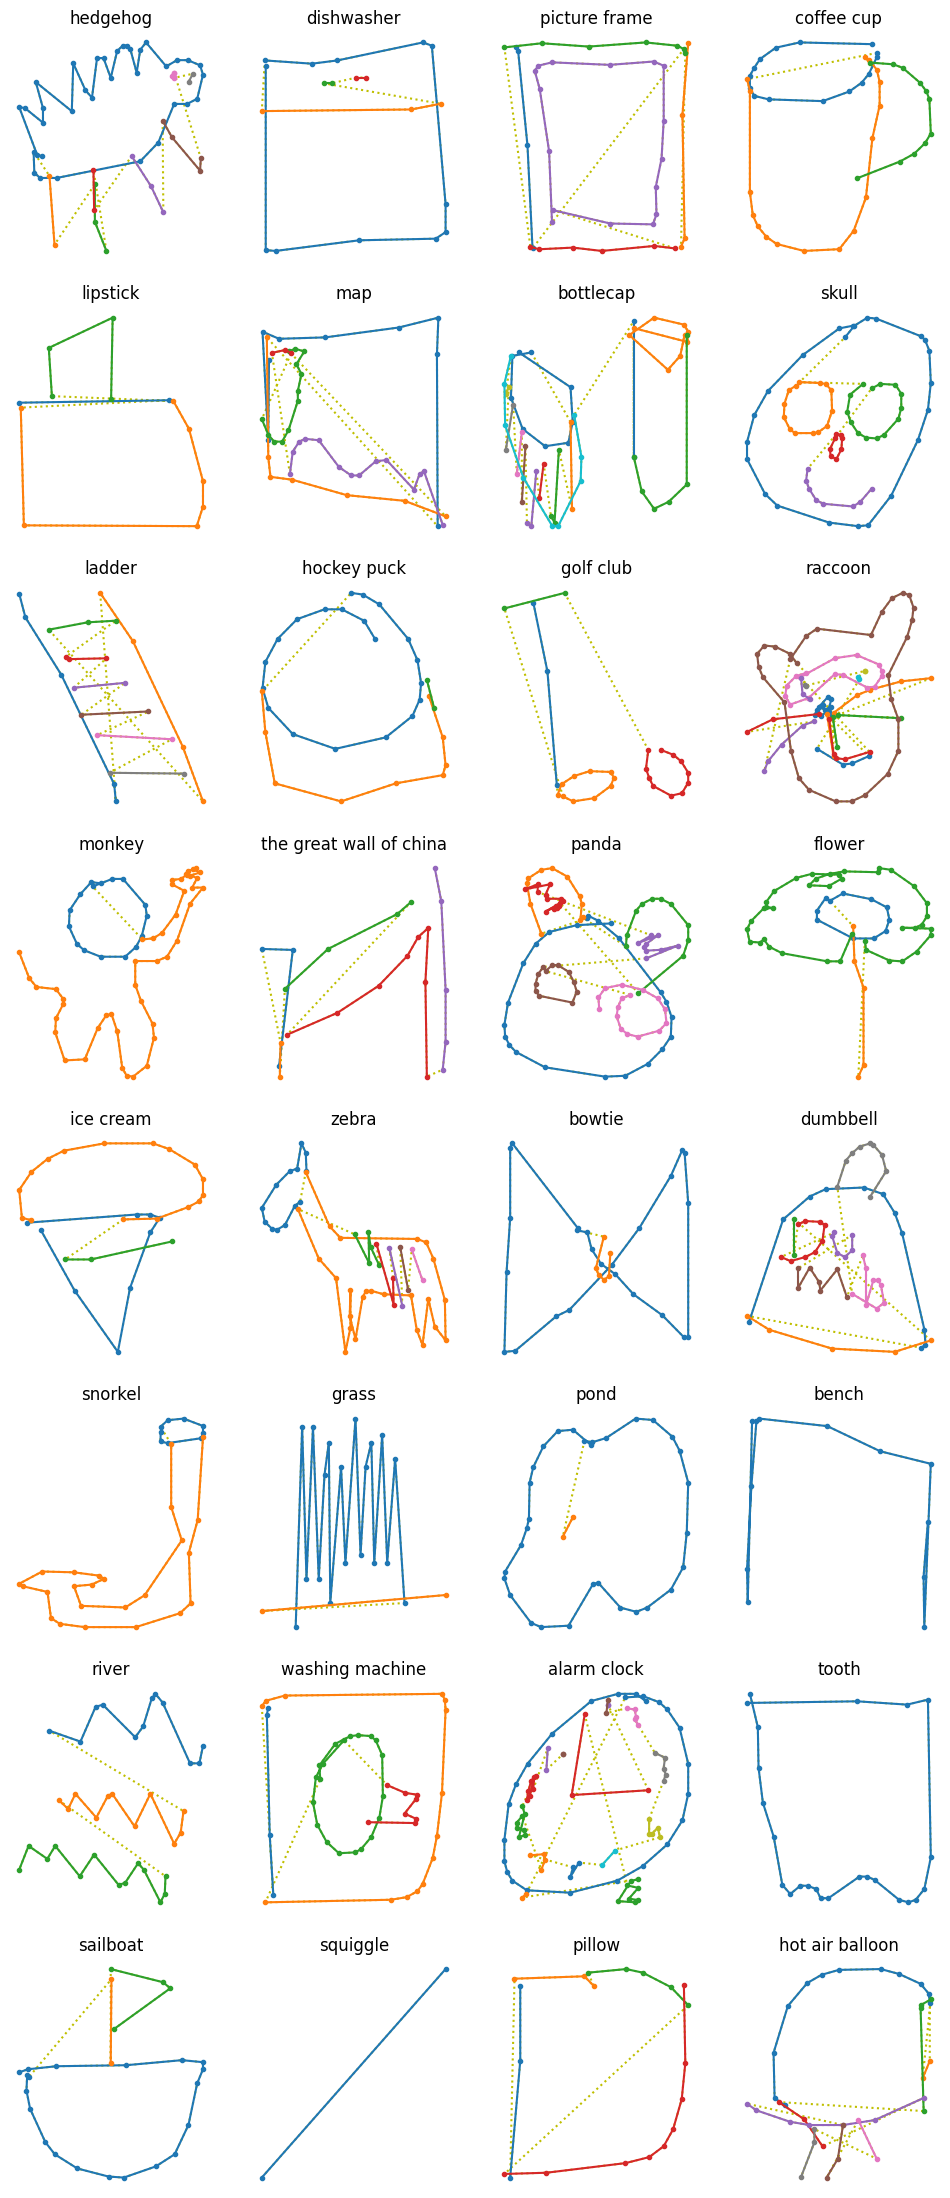

In [73]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1] == 1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else 'Try to guess'
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], 'y:')
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], '.-')
    plt.axis('off')


def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()


for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

대부분의 스케치는 100개 포인트 이하로 구성되어 있다:

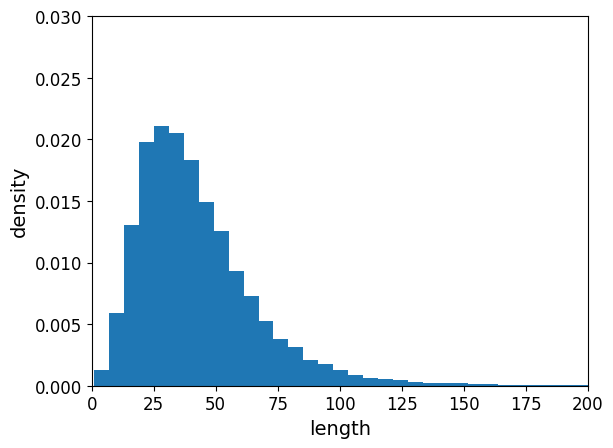

In [74]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, 150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel('length')
plt.ylabel('density')
plt.show()

In [75]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))


cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = keras.models.Sequential(
    [
        keras.layers.Conv1D(32, 5, 2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, 5, 2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, 2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(128),
        keras.layers.Dense(len(class_names), 'softmax')
    ]
)
optimizer = keras.optimizers.SGD(clipnorm=1.)
model.compile(optimizer, 'sparse_categorical_crossentropy', ['accuracy', 'sparse_top_k_categorical_accuracy'])
history = model.fit(cropped_train_set, epochs=2, validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2261s 21ms/step - loss: 4.0907 - accuracy: 0.1691 - sparse_top_k_categorical_accuracy: 0.3725 - val_loss: 3.0813 - val_accuracy: 0.3081 - val_sparse_top_k_categorical_accuracy: 0.5919
Epoch 2/2
107813/107813 [==============================] - ETA: 0s - loss: 2.6907 - accuracy: 0.3817 - sparse_top_k_categorical_accuracy: 0.6716

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, 5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print(f'Top-5 predictions: {index + 1}')
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print(f'  {k + 1}. {class_name} {proba:.3f}%')
    print(f'Answer: {class_names[labels[index].numpy()]}')

In [ ]:
model.save('my_sketchrnn')

## 2. 바흐 합창곡

_연습: [바흐 합창곡](https://homl.info/bach) 데이터셋을 다운로드하여 압축을 푼다. 이 데이터셋은 요한 제바스티안 바흐가 작곡한 382개의 합창곡으로 구성되어 있다. 각 곡은 100에서 640까지 타임 스텝 길이이다. 각 타임 스텝은 4개의 정수를 담고 있다. 각 정수는 피아노 음표의 인덱스에 해당한다(연주되는 음표가 없다는 것을 의미하는 0은 제외). 코랄의 타임 스텝 시퀀스가 주어지면 다음 타임 스텝(4개의 음표)을 예측할 수 있는 순환 모델, 합성곱 모델 또는 두 가지를 합친 모델을 훈련한다. 그다음 이 모델을 사용해 한 번에 하나의 음표씩 바흐와 같은 음악을 생성한다. 코랄의 시작 부분을 모델에 주입하고 다음 타임 스텝을 예측한다. 이 타임 스텝을 입력 시퀀스에 추가하여 모델이 다음 음표를 예측하게 만드는 식이다. 또 바흐를 위한 [구글 두들](https://www.google.com/doodles/celebrating-johann-sebastian-bach)에 사용한 구글의 [Coconet 모델](https://homl.info/coconet)을 확인해 본다._

In [ ]:
DOWNLOAD_ROOT = 'https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/'
FILENAME = 'jsb_chorales.tgz'
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, cache_subdir='datasets/jsb_chorales', extract=True)

In [ ]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob('train/chorale_*.csv'))
valid_files = sorted(jsb_chorales_dir.glob('valid/chorale_*.csv'))
test_files = sorted(jsb_chorales_dir.glob('test/chorale_*.csv'))

In [ ]:
import pandas as pd


def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]


train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

음표의 범위는 36(C1 = 옥타브 1의 C)에서 81(A5 = 옥타브 5의 A)까지이고 무음을 위해 0을 추가한다:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)
n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)
assert min_note == 36
assert max_note == 81

이 코랄을 듣기 위한 몇 개의 함수를 만들어 본다(사실 MIDI 플레이어처럼 더 간단한 방법이 있지만 그냥 하나의 합성기(synthesizer)를 만들어 보았다):

In [ ]:
from IPython.display import Audio
from scipy.io import wavfile


def notes_to_frequencies(notes):
    # 한 옥타브 올라갈 때 주파수는 두배가 된다.
    # 옥타브마다 12개의 반음이 있다.
    # 옥타브 4의 A는 440Hz이고 음표 번호는 69이다.
    return 2 ** ((np.array(notes) - 69) / 12) * 440


def frequencies_to_samples(frequencies, tempo, sample_rate):
    # tempo는 분당 박자 수로 측정한다.
    note_duration = 60 / tempo
    # 매 박자마다 딸깍거리는 소리를 줄이기 위해 주파수를 반올림하여 각 음의 끝에서 샘플을 0에 가깝게 만든다.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # (음표 0 = 무음을 포함해) 9Hz 이하인 주파수는 모두 삭제한다.
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)


def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    # 마지막 음표를 조금 더 길게 한다.
    freqs = np.r_[freqs, freqs[-1:]]
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate) for melody in freqs.T], axis=0)
    # 마지막 음을 희미하게 한다.
    n_fade_out_samples = sample_rate * 60 // tempo
    fade_out = np.linspace(1., 0., n_fade_out_samples) ** 2
    merged[-n_fade_out_samples:] *= fade_out
    return merged


def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        samples = (2 ** 15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

이제 몇 개의 코랄을 들어 보자:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

새로운 코랄을 생성하기 위해서는 이전의 화음이 주어졌을 때 다음 화음을 예측할 수 있는 모델을 훈련해야 한다. 한 번에 4개의 음표를 예측하는 식으로 다음 화음을 예측한다면 잘 어울리지 않는 음표를 얻게 된다. 한 번에 하나의 음표를 예측하는 것이 간단하고 더 낫다. 따라서 모든 코랄을 전처리하여 각 화음을 아르페지오로 바꾸어야 한다(즉, 동시에 연주되는 음표가 아니라 음표의 시퀀스). 그다음 이전의 모든 음표가 주어졌을 때 다음 음표를 예측하는 모델을 훈련할 수 있다. 시퀀스-투-시퀀스 방식을 사용한다. 신경망에 한 윈도를 주입하고 한 타임 스텝 미래로 이동한 윈도를 예측한다.

또한 0에서 46까지 범위를 갖도록 값을 이동시킨다. 여기에서 0은 무음을 나타내고 1에서 46까지는 36(C1)에서 81(A5)까지를 나타낸다.

128 음표(즉, 32개 화음)의 윈도에서 모델을 훈련한다.

이 데이터셋은 메모리에 올라갈 수 있기 때문에 파이썬 코드를 사용해 RAM에서 코랄을 전처리할 수 있지만 여기에서는 tf.data를 사용해 전처리하는 방법을 시연한다.

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:]  # 각 스텝에서 아르페지오에 있는 다음 음표를 예측한다
    return X, Y


def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1)  # 값 이동
    return tf.reshape(window, [-1])  # 아르페지오로 변환


def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None, window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(AUTOTUNE)

훈련 세트, 검증 세트, 테스트 세트를 만든다:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

이제 모델을 만든다:

* 음표를 실수 값으로 모델에 직접 주입할 수 있지만 좋은 결과를 얻지 못할 것이다. 음표 간의 관계는 단순하지 않다. 예를 들어 C3을 C4로 바꾼다면 두 음표 사이에 반음이 12개(즉 한 옥타브) 떨어져 있음에도 멜로디는 여전히 괜찮게 들린다. 반대로 C3을 C\#3으로 바꾼다면 바로 다음 음표임에도 화음이 매우 좋지 않다. 따라서 `Embedding` 층을 사용해 음표를 작은 벡터 표현으로 바꾸겠다(임베딩에 대해서는 16장을 참고하세요). 5-차원 임베딩을 사용하므로 첫 번째 층의 출력은 `[batch_size, window_size, 5]` 크기가 된다.
* 그 다음 이 데이터를 4개의 `Conv1D` 층을 쌓고 dilation 비율을 두 배씩 늘린 작은 WeveNet 신경망에 주입한다. 빠른 수렴을 위해 이 층 다음에 `BatchNormalization` 층을 배치한다.
* 그다음 하나의 `LSTM` 층이 장기 패턴을 감지한다.
* 마지막으로 `Dense` 층이 최종 음표 확률을 생성한다. 타임 스텝과 (무음을 포함해) 가능한 음표마다 배치에 있는 각 코랄에 대해 하나의 확률을 예측한다. 따라서 출력 크기는 `[batch_size, window_size, 47]`가 됩니다.

In [ ]:
n_embedding_dims = 5
model = keras.models.Sequential(
    [
        keras.layers.Embedding(n_notes, n_embedding_dims, input_shape=[None]),
        keras.layers.Conv1D(32, 2, padding='causal', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(48, 2, padding='causal', dilation_rate=2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, 2, padding='causal', dilation_rate=4, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(96, 2, padding='causal', dilation_rate=8, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(256, return_sequences=True),
        keras.layers.Dense(n_notes, 'softmax')
    ]
)
model.summary()

이제 모델을 컴파일하고 훈련할 준비가 되었다!

In [ ]:
optimizer = keras.optimizers.Nadam()
model.compile(optimizer, 'sparse_categorical_crossentropy', ['accuracy'])
model.fit(train_set, epochs=20, validation_data=valid_set)

여기서는 하이퍼파라미터 탐색을 많이 수행하지 않았다. 자유롭게 이 모델을 사용해 하이퍼파라미터를 탐색하고 최적화해 볼 수 있다. 예를 들어 `LSTM` 층을 제거하고 `Conv1D` 층으로 바꿀 수 있다. 층의 개수, 학습률, 옵티마이저 등을 실험해 볼 수 있다.

검증 세트에 대한 모델의 성능이 만족스럽다면 모델을 저장하고 테스트 세트에서 마지막으로 평가한다:

In [ ]:
model.save('my_bach_model.h5')
model.evaluate(test_set)

**노트:** 이 연습에서는 테스트 세트가 필요하지 않다. 모델이 생성한 음악을 듣는 것이 최종 평가가 되기 때문이다. 따라서 필요하다면 테스트 세트를 훈련 세트에 넣고 모델을 다시 훈련하여 조금 더 나은 모델을 얻을 수 있다.

이제 새로운 코럴을 생성하는 함수를 만들어 본다. 몇 개의 시드 화음을 주고 이를 (모델이 기대하는 포맷인) 아르페지오로 변환한다. 그다음 모델을 사용해 다음 음표을 예측한다. 마지막에 4개씩 음표를 모아서 다시 화음을 만들고 최종 코럴을 반환한다.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            # next_note = model.predict_classes(arpegio)[:1, -1:]
            next_note = np.argmax(model.predict(arpegio), -1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], 1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

이 함수를 테스트하려면 시드 화음이 필요하다. 테스트 코럴 중 하나에 있는 처음 8개의 화음을 사용해 본다(실제로 이는 4번 반복되는 2개의 화음이다):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

첫 번째 코럴을 생성할 준비를 마쳤다! 56개의 화음을 생성하여 총 64개의 화음, 즉 4 소절(소절마다 4개의 화음인 4/4박으로 가정한다)을 만들어 보겠다:

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

이 방식에는 한가지 단점이 있다. 너무 보수적인 경우가 많다. 실제로 이 모델은 모험을 하지 않아 항상 가장 높은 확률의 음표를 선택한다. 이전 음표를 반복하면 충분히 듣기 좋고 가장 덜 위험하기 때문에 이 알고리즘은 마지막 음표를 오래 지속시키는 경향이 있다. 상당히 지루하다. 또한 이 모델을 여러 번 실행하면 항상 같은 멜로디를 생성할 것이다.

조금 더 신나게 만들어 보자! 항상 가장 높은 점수의 음표를 선택하는 대신, 예측된 확률을 기반으로 랜덤하게 다음 음표를 선택한다. 예를 들어, 모델이 75% 확률로 C3를 예측하고 25% 확률로 G3를 예측했다면 이 확률대로 랜덤하게 두 음표 중 하나를 선택한다. 또한 `temperature` 매개변수를 추가하여 시스템의 온도(즉 대담성)를 제어한다. 높은 온도는 예측 확률을 비슷하게 만들어 가능성이 높은 음표의 확률을 줄이고 가능성이 낮은 음표의 확률을 높인다:

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, 1)
            arpegio = tf.concat([arpegio, next_note], 1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

이 함수로 3개의 코랄을 생성해 보겠다. 하나는 차갑게, 하나는 중간으로, 하나는 뜨겁게 만든다(시드, 길이, 온도를 사용해 자유롭게 실험해 본다). 다음 코드는 각 코랄을 별개의 파일에 저장한다. 마음에 드는 음악을 만날 때까지 이 셀을 반복해서 실행할 수 있다!

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, 0.8)
play_chords(new_chorale_v2_cold, filepath='bach_cold.wav')

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, 1.0)
play_chords(new_chorale_v2_medium, filepath='bach_medium.wav')

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, 1.5)
play_chords(new_chorale_v2_hot, filepath='bach_hot.wav')

마지막으로 재미있는 실험을 해 볼 수 있다. 친구에게 마음에 드는 코럴 몇 개와 진짜 코럴을 보내고 어떤 것이 진짜인지 물어 보자!:

In [ ]:
play_chords(test_chorales[2][:64], filepath='bach_test_4.wav')